In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=128
transform=transforms.ToTensor()
train_ds=datasets.MNIST(root='./data',train=True,download=True,transform=transform)
train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.96MB/s]


In [ ]:
import math
class VAE(nn.Module):
    def __init__(self, z_dim=20):

        super().__init__()

        self.fc1 = nn.Linear(28*28,400)

        self.fc_mu = nn.Linear(400,z_dim) # mean

        self.fc_logvar = nn.Linear(400,z_dim) #std deviation prediction

        self.fc3 = nn.Linear(z_dim,400)

        self.fc4=nn.Linear(400,28*28)

    def encode(self,x):

        h=F.relu(self.fc1(x))

        return self.fc_mu(h),self.fc_logvar(h)

    def reparameterize(self,mu,logvar):

        std=torch.exp(0.5*logvar)

        eps=torch.randn_like(std)

        return mu+eps*std

    def decode(self,z):

        h=F.relu(self.fc3(z))

        return torch.sigmoid(self.fc4(h))

    def forward(self,x):

        x=x.view(-1,28*28)

        mu,logvar=self.encode(x)

        z=self.reparameterize(mu,logvar)

        recon=self.decode(z)
        return recon,mu,logvar
model=VAE().to(device)


In [ ]:
def vae_loss(recon,x,mu,logvar):
    b=x.size(0)
    x=x.view(b,-1)
    bce=F.binary_cross_entropy(recon,x,reduction='sum')
    kld=-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    return (bce+kld)/b


In [ ]:
from torchvision.utils import make_grid
import torch.optim as optim
epochs=20
opt=optim.Adam(model.parameters(),lr=1e-3)
model.train()
for epoch in range(1,epochs+1):
    for x,_ in train_loader:
        x=x.to(device)
        recon,mu,logvar=model(x)
        loss=vae_loss(recon,x,mu,logvar)
        opt.zero_grad()
        loss.backward()
        opt.step()
model.eval()
with torch.no_grad():
    z=torch.randn(64,20,device=device)
    gen=model.decode(z).view(-1,1,28,28).cpu()
    gen_grid=make_grid(gen,nrow=8)
    x,_=next(iter(train_loader))
    x=x.to(device)[:64]
    recon,_,_=model(x)
    recon=recon.view(-1,1,28,28).cpu()
    recon_grid=make_grid(recon,nrow=8)
    inp_grid=make_grid(x.view(-1,1,28,28).cpu(),nrow=8)


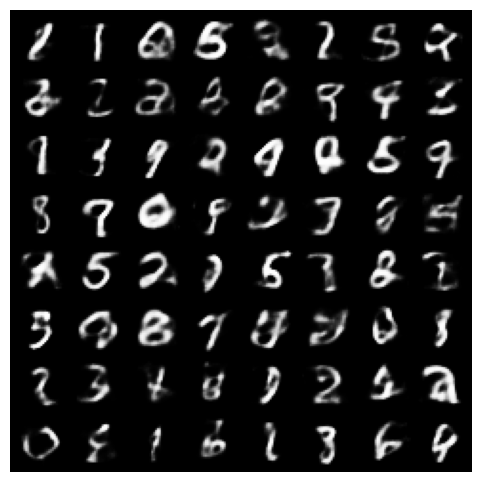

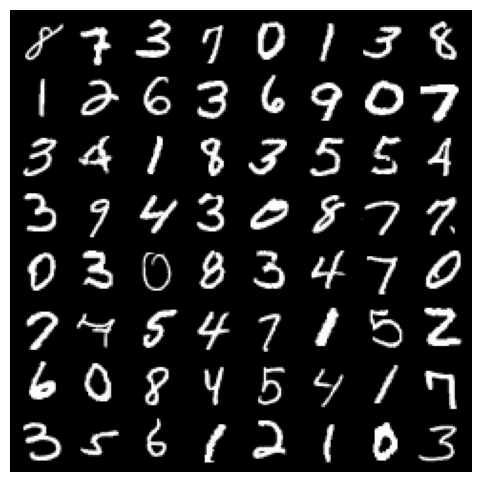

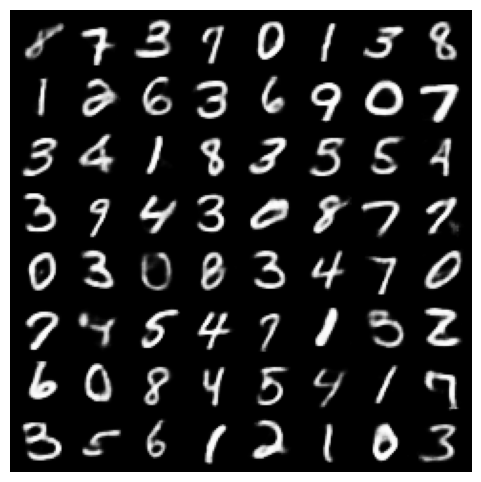

In [ ]:
import matplotlib.pyplot as plt
def show(t):
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(t.permute(1,2,0).squeeze(),cmap='gray')
show(gen_grid)
show(inp_grid)
show(recon_grid)


In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
torch.manual_seed(0)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bs=128
tx=transforms.Compose([transforms.Resize(64),transforms.CenterCrop(64),transforms.ToTensor()])
ds_full=datasets.OxfordIIITPet(root='./data',split='trainval',target_types='category',transform=tx,download=True)
cat_names=['Abyssinian','Bengal','Birman','Bombay','Persian','Ragdoll','Siamese','Sphynx']
cat_idx={ds_full.class_to_idx[n] for n in cat_names}
idxs=[i for i in range(len(ds_full)) if ds_full[i][1] in cat_idx]
ds=Subset(ds_full,idxs)
dl=DataLoader(ds,batch_size=bs,shuffle=True,num_workers=2,pin_memory=True)


100%|██████████| 792M/792M [10:30<00:00, 1.26MB/s]
100%|██████████| 19.2M/19.2M [00:04<00:00, 4.12MB/s]


In [ ]:
class VAE(nn.Module):
    def __init__(self,z_dim=128):
        super().__init__()
        self.enc=nn.Sequential(
            nn.Conv2d(3,64,4,2,1),nn.ReLU(True),
            nn.Conv2d(64,128,4,2,1),nn.BatchNorm2d(128),nn.ReLU(True),
            nn.Conv2d(128,256,4,2,1),nn.BatchNorm2d(256),nn.ReLU(True),
            nn.Conv2d(256,512,4,2,1),nn.BatchNorm2d(512),nn.ReLU(True))
        self.fc_mu=nn.Linear(512*4*4,z_dim)
        self.fc_lv=nn.Linear(512*4*4,z_dim)  #at this point we get z
        self.fc_dec=nn.Linear(z_dim,512*4*4)
        self.dec=nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1),nn.BatchNorm2d(256),nn.ReLU(True), #8x8
            nn.ConvTranspose2d(256,128,4,2,1),nn.BatchNorm2d(128),nn.ReLU(True), #16x16
            nn.ConvTranspose2d(128,64,4,2,1),nn.BatchNorm2d(64),nn.ReLU(True), #32x32
            nn.ConvTranspose2d(64,3,4,2,1),nn.Sigmoid()) #64x64
    def encode(self,x):
        h=self.enc(x).view(x.size(0),-1)
        return self.fc_mu(h),self.fc_lv(h)
    def reparameterize(self,mu,lv):
        std=(0.5*lv).exp()
        eps=torch.randn_like(std)
        return mu+eps*std
    def decode(self,z):
        h=self.fc_dec(z).view(z.size(0),512,4,4)
        return self.dec(h)
    def forward(self,x):
        mu,lv=self.encode(x)
        z=self.reparameterize(mu,lv)
        recon=self.decode(z)
        return recon,mu,lv
model=VAE().to(device)


In [ ]:
def vae_loss(recon,x,mu,lv):
    b=x.size(0)
    bce=F.binary_cross_entropy(recon,x,reduction='sum')
    kld=-0.5*torch.sum(1+lv-mu.pow(2)-lv.exp())
    return (bce+kld)/b


In [ ]:
import torch.optim as optim
epochs=300
opt=optim.Adam(model.parameters(),lr=2e-4,betas=(0.9,0.999))
model.train()
for ep in range(epochs):
    for x,_ in dl:
        x=x.to(device)
        recon,mu,lv=model(x)
        loss=vae_loss(recon,x,mu,lv)
        opt.zero_grad()
        loss.backward()
        opt.step()
model.eval()
with torch.no_grad():
    z=torch.randn(64,128,device=device)
    gen=model.decode(z).cpu()
    x,_=next(iter(dl))
    x=x.to(device)[:64]
    r,_,_=model(x)
    gen_grid=make_grid(gen,8)
    inp_grid=make_grid(x.cpu(),8)
    rec_grid=make_grid(r.cpu(),8)


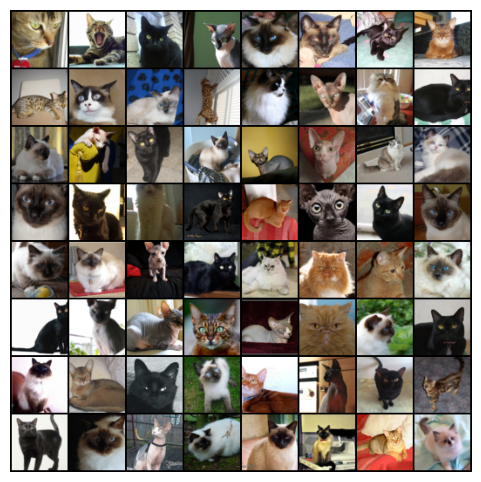

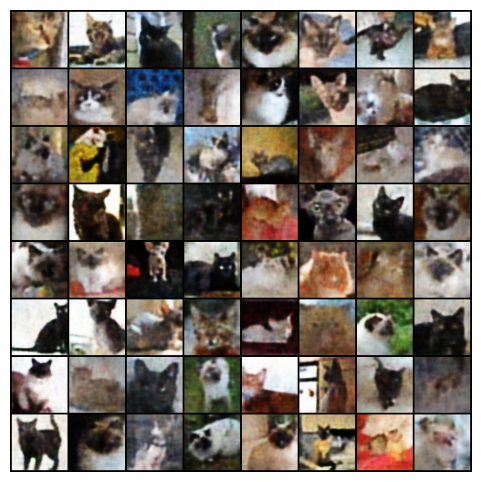

In [ ]:
def show(t):
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(t.permute(1,2,0))
show(inp_grid)
show(rec_grid)
